In [1]:
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plot_config
plot_config.set_config()

In [2]:
t_importance = load('../data/elec2_ninc/importance.joblib')
t_fname = load('../data/elec2_ninc/fnames.joblib')[:-1]
dic = sorted([(k,v) for k,v in zip(t_importance, t_fname)])[-15:]
importance = [k for k,v in dic]
fname = [v for k,v in dic]
pos = np.arange(len(importance))

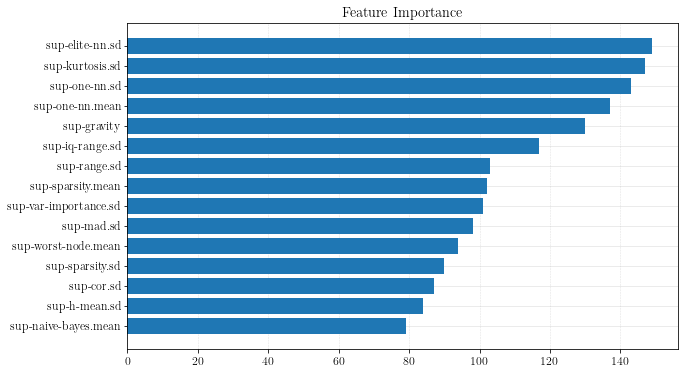

In [3]:
fig, ax1 = plt.subplots(figsize=(10,6))
fig.subplots_adjust(left=0.115, right=0.88)
ax1.set_title('Feature Importance')
ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
rects = plt.barh(pos, importance,
         align='center',
         tick_label=[x.replace('_','-') for x in fname])

In [4]:
arange = 1000
difference = np.array(load('../data/elec2_ninc/difference.joblib'))
cum = np.cumsum(difference)[:arange]
x = np.arange(arange)

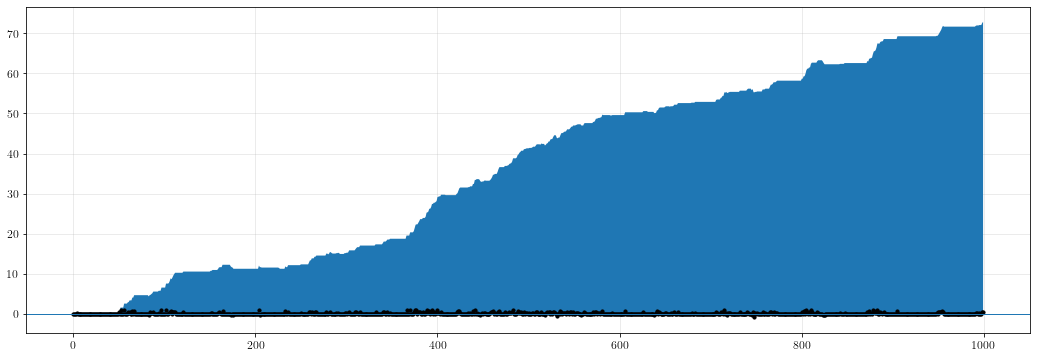

In [5]:
plt.figure(figsize=(18, 6))
plt.fill_between(x, cum, 0)
plt.scatter(x, difference[:arange], s=10, c='black')
plt.axhline(0);

In [6]:
print(cum[-10:])

[71.7 71.9 72.  72.  72.  72.1 72.1 72.1 72.6 72.9]


In [7]:
with open('../elec2-ninc.output') as fin:
    print(fin.read())

[FINETUNING BASE MODELS]
[GENERATE METAFEATURE]
Frequency statistics in metabase:
	SVC                      0.530
	RandomForestClassifier   0.400
	GaussianNB               0.070
[OFFLINE LEARNING]
Kappa:    0.070
GMean:    0.228
Accuracy: 0.510
[[108  50   1]
 [ 70  44   6]
 [ 11   9   1]]
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       159
           1       0.43      0.37      0.39       120
           2       0.12      0.05      0.07        21

    accuracy                           0.51       300
   macro avg       0.37      0.36      0.36       300
weighted avg       0.48      0.51      0.49       300

                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.68      0.43      0.62      0.54      0.30       159
          1       0.43      0.37      0.67      0.39      0.50      0.24       120
          2       0.12      0.05      0.97      0.07      0.22      0.04      

In [8]:
metadf = load('../data/elec2_ninc/metadf.joblib')
best = np.array(load('../data/elec2_ninc/best.joblib'))
score_recommended = np.array(load('../data/elec2_ninc/score_reco.joblib'))
score_default = np.array(load('../data/elec2_ninc/score_def.joblib'))

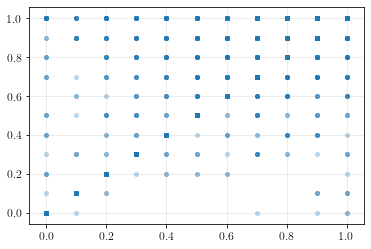

In [9]:
plt.scatter(score_default, score_recommended, alpha=.25)

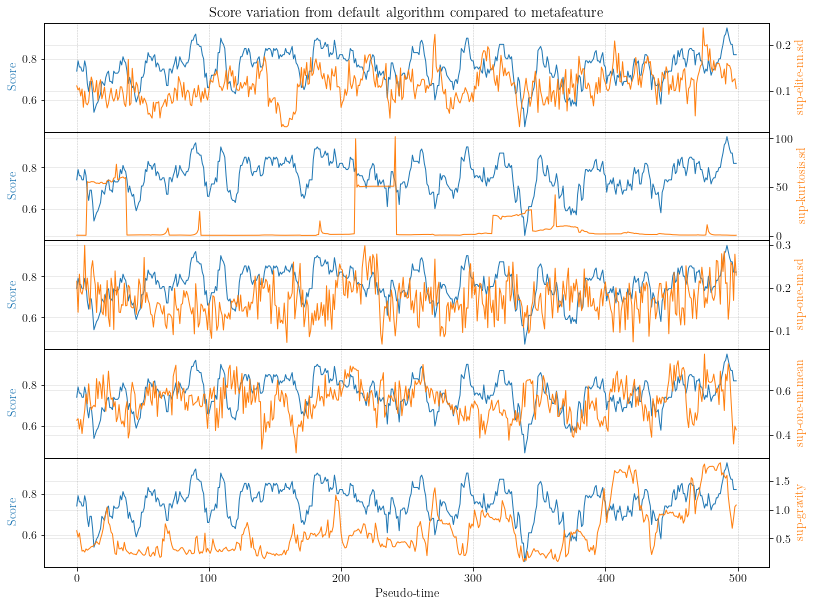

In [10]:
window_score = 500
N = 10
n_feats = 5
sorted_feats = np.argsort(t_importance)[::-1]
moving_avg = np.convolve(score_default[-(window_score+N-1):], np.ones((N,))/N, mode='valid')
fig, ax = plt.subplots(n_feats, figsize=(13,10), sharex=True,gridspec_kw={'hspace': 0})
for idx,i in enumerate(sorted_feats[:n_feats]):
    ax1 = ax[idx]
    if idx == 0:
        ax1.set_title("Score variation from default algorithm compared to metafeature")
    if idx == n_feats-1:
        ax1.set_xlabel("Pseudo-time")
    ax1.xaxis.grid(linestyle='--', alpha=.75)
    ax1.plot(moving_avg, color='C0')
    ax1.set_ylabel("Score", color='C0')
    ax2 = ax1.twinx()
    ax2.plot(metadf[-window_score:,i], color='C1')
    ax2.set_ylabel("{}".format(t_fname[i].replace('_','-')), color='C1')

In [11]:
len(moving_avg)

500

In [12]:
df = pd.DataFrame(metadf[-window_score:], columns=t_fname)
df.rename(columns={x:x.replace('_','-') for x in t_fname}, inplace=True)
df['score-default'] = moving_avg

In [13]:
sel_cols = [x.replace('_','-') for x in list(t_fname[sorted_feats][:4].values)]+['score-default']

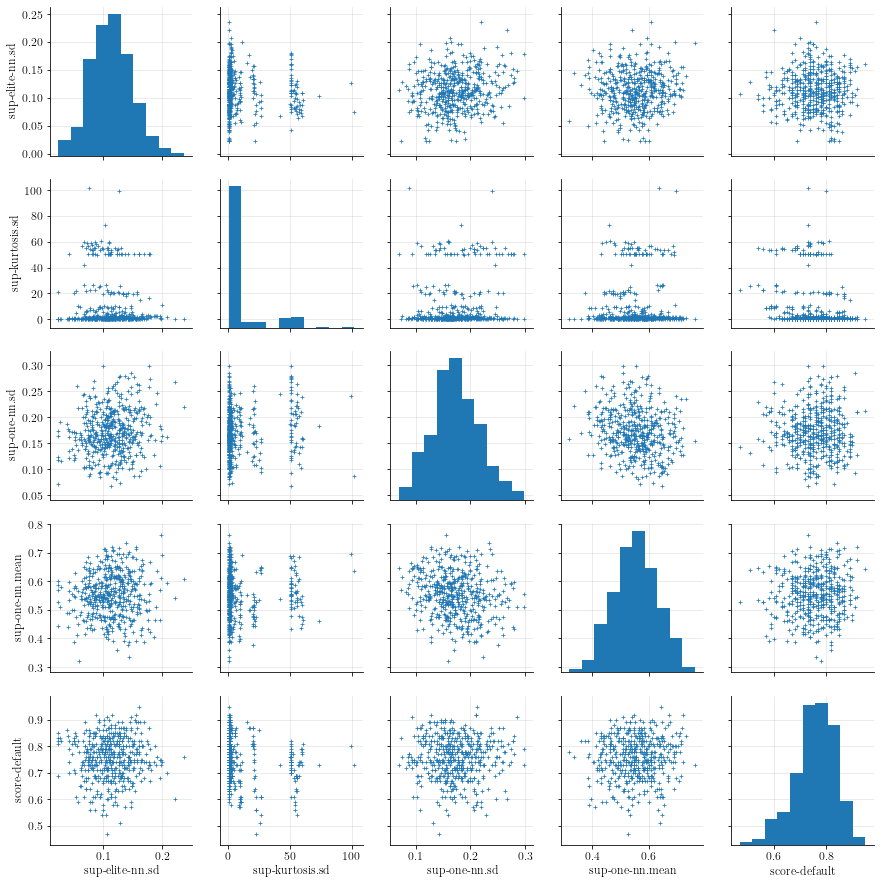

In [14]:
g = sns.pairplot(df.loc[-window_score:,sel_cols], markers="+")

In [15]:
model = sm.OLS(df['score-default'], df.drop(columns=['score-default']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          score-default   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     11.60
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           1.36e-69
Time:                        18:00:05   Log-Likelihood:                 872.99
No. Observations:                 500   AIC:                            -1570.
Df Residuals:                     412   BIC:                            -1199.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
sup-attr-conc.mean    

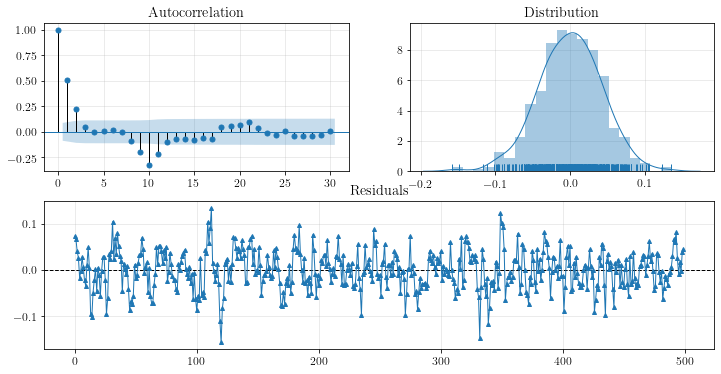

In [16]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(212)
ax1.set_title('Residuals')
ax1.axhline(0, linestyle='--', color='k')
ax1.plot(results.resid, '^-')
ax2 = plt.subplot(221)
sm.graphics.tsa.plot_acf(results.resid, ax=ax2, lags=30)
ax3 = plt.subplot(222)
ax3.set_title('Distribution')
sns.distplot(results.resid, rug=True, ax=ax3);

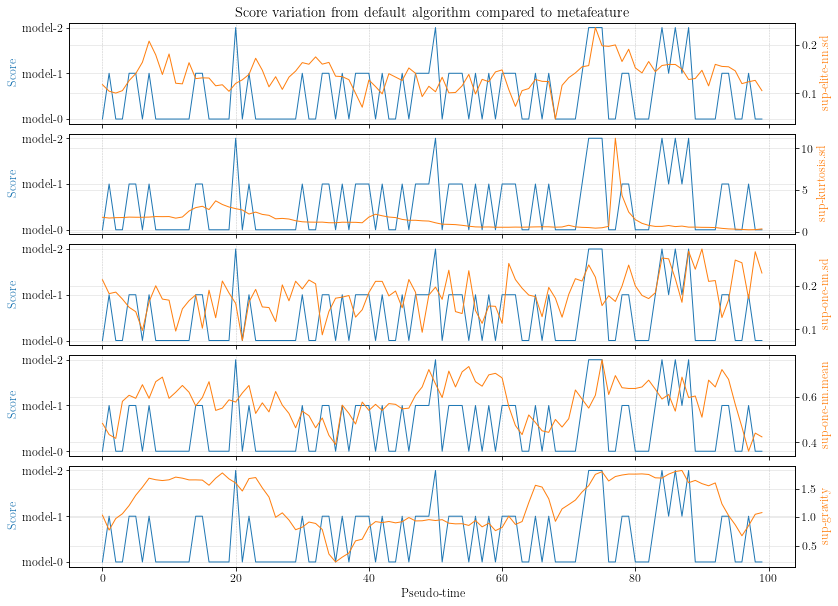

In [17]:
window_score = 100
N = 10
n_feats = 5
sorted_feats = np.argsort(t_importance)[::-1]
best_model = ['model-{}'.format(x) for x in best[:window_score]]
fig, ax = plt.subplots(n_feats, figsize=(13,10), sharex=True,gridspec_kw={'hspace': 0.1})
for idx,i in enumerate(sorted_feats[:n_feats]):
    ax1 = ax[idx]
    if idx == 0:
        ax1.set_title("Score variation from default algorithm compared to metafeature")
    if idx == n_feats-1:
        ax1.set_xlabel("Pseudo-time")
    ax1.xaxis.grid(linestyle='--', alpha=.75)
    ax1.plot(best_model, color='C0')
    ax1.set_ylabel("Score", color='C0')
    ax2 = ax1.twinx()
    ax2.plot(metadf[-window_score:,i], color='C1')
    ax2.set_ylabel("{}".format(t_fname[i].replace('_','-')), color='C1')